In [1]:
import xarray as xr
import os
import pandas as pd
import functions.eddy_feedback as ef
import numpy as np

In [15]:
data_path = '/home/links/ct715/data_storage/PAMIP/processed_daily/daily_efp_mon-avg'
models = sorted(os.listdir(data_path))

ds = {}
for model in models:
    
    path = os.path.join(data_path, model)
    files = os.path.join(path, '*.nc')
    if len(files) == 0:
        print(f'No files found for {model}')
        continue
    ds[model] = xr.open_mfdataset(files, concat_dim='ens_ax', combine='nested')
    

In [3]:
efp_data = []

for model in models:
    dataset = ds[model]
    
    efp_nh = ef.calculate_efp(dataset, data_type='pamip', calc_south_hemis=False)
    efp_sh = ef.calculate_efp(dataset, data_type='pamip', calc_south_hemis=True)
    
    efp_data.append({'model': model, 'efp_nh': efp_nh, 'efp_sh': efp_sh})

efp_df = pd.DataFrame(efp_data)
efp_df

,model,efp_nh,efp_sh
0,AWI-CM-1-1-MR,0.2592,0.2557
1,CNRM-CM6-1,0.2244,0.1944
2,CanESM5,0.3133,0.3271
3,FGOALS-f3-L,0.2353,0.1273
4,HadGEM3-GC31-LL,0.0446,0.1728
5,HadGEM3-GC31-MM,0.2525,0.1874
6,IPSL-CM6A-LR,0.2623,0.2015
7,MIROC6,0.1592,0.2058


- AWI (ECHAM): Can't compare to my monthly values. Should check Rosie's
- CNRM (daily): Pretty close!
- CanESM (6h): Quite far away (~0.1)
- FGOALS (daily): Almost identical!
- HadGEM both need redoing
- IPSL (daily): Very close!
- MIROC (daily): Not that close (although monthly values have missing values)

In [20]:
hadll = ds[models[4]]
hadmm = ds[models[5]]

### HadGEM3-GC31-LL
- 1000 hPa contains weird values, best to remove
- Ensemble members 27,28 (r125 and r126) have been removed

In [21]:
hadll = hadll.where(hadll.level < 1000.) 

# members = np.delete(hadll.ens_ax.values, [27,28])
members = np.delete(hadll.ens_ax.values, [25,26,27,28,34,53,56,57])
hadll = hadll.sel(ens_ax=members)

In [22]:
hadll.ens_ax.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [23]:
print(ef.calculate_efp(hadll, data_type='pamip', calc_south_hemis=False))
print(ef.calculate_efp(hadll, data_type='pamip', calc_south_hemis=True))

0.1727
0.173


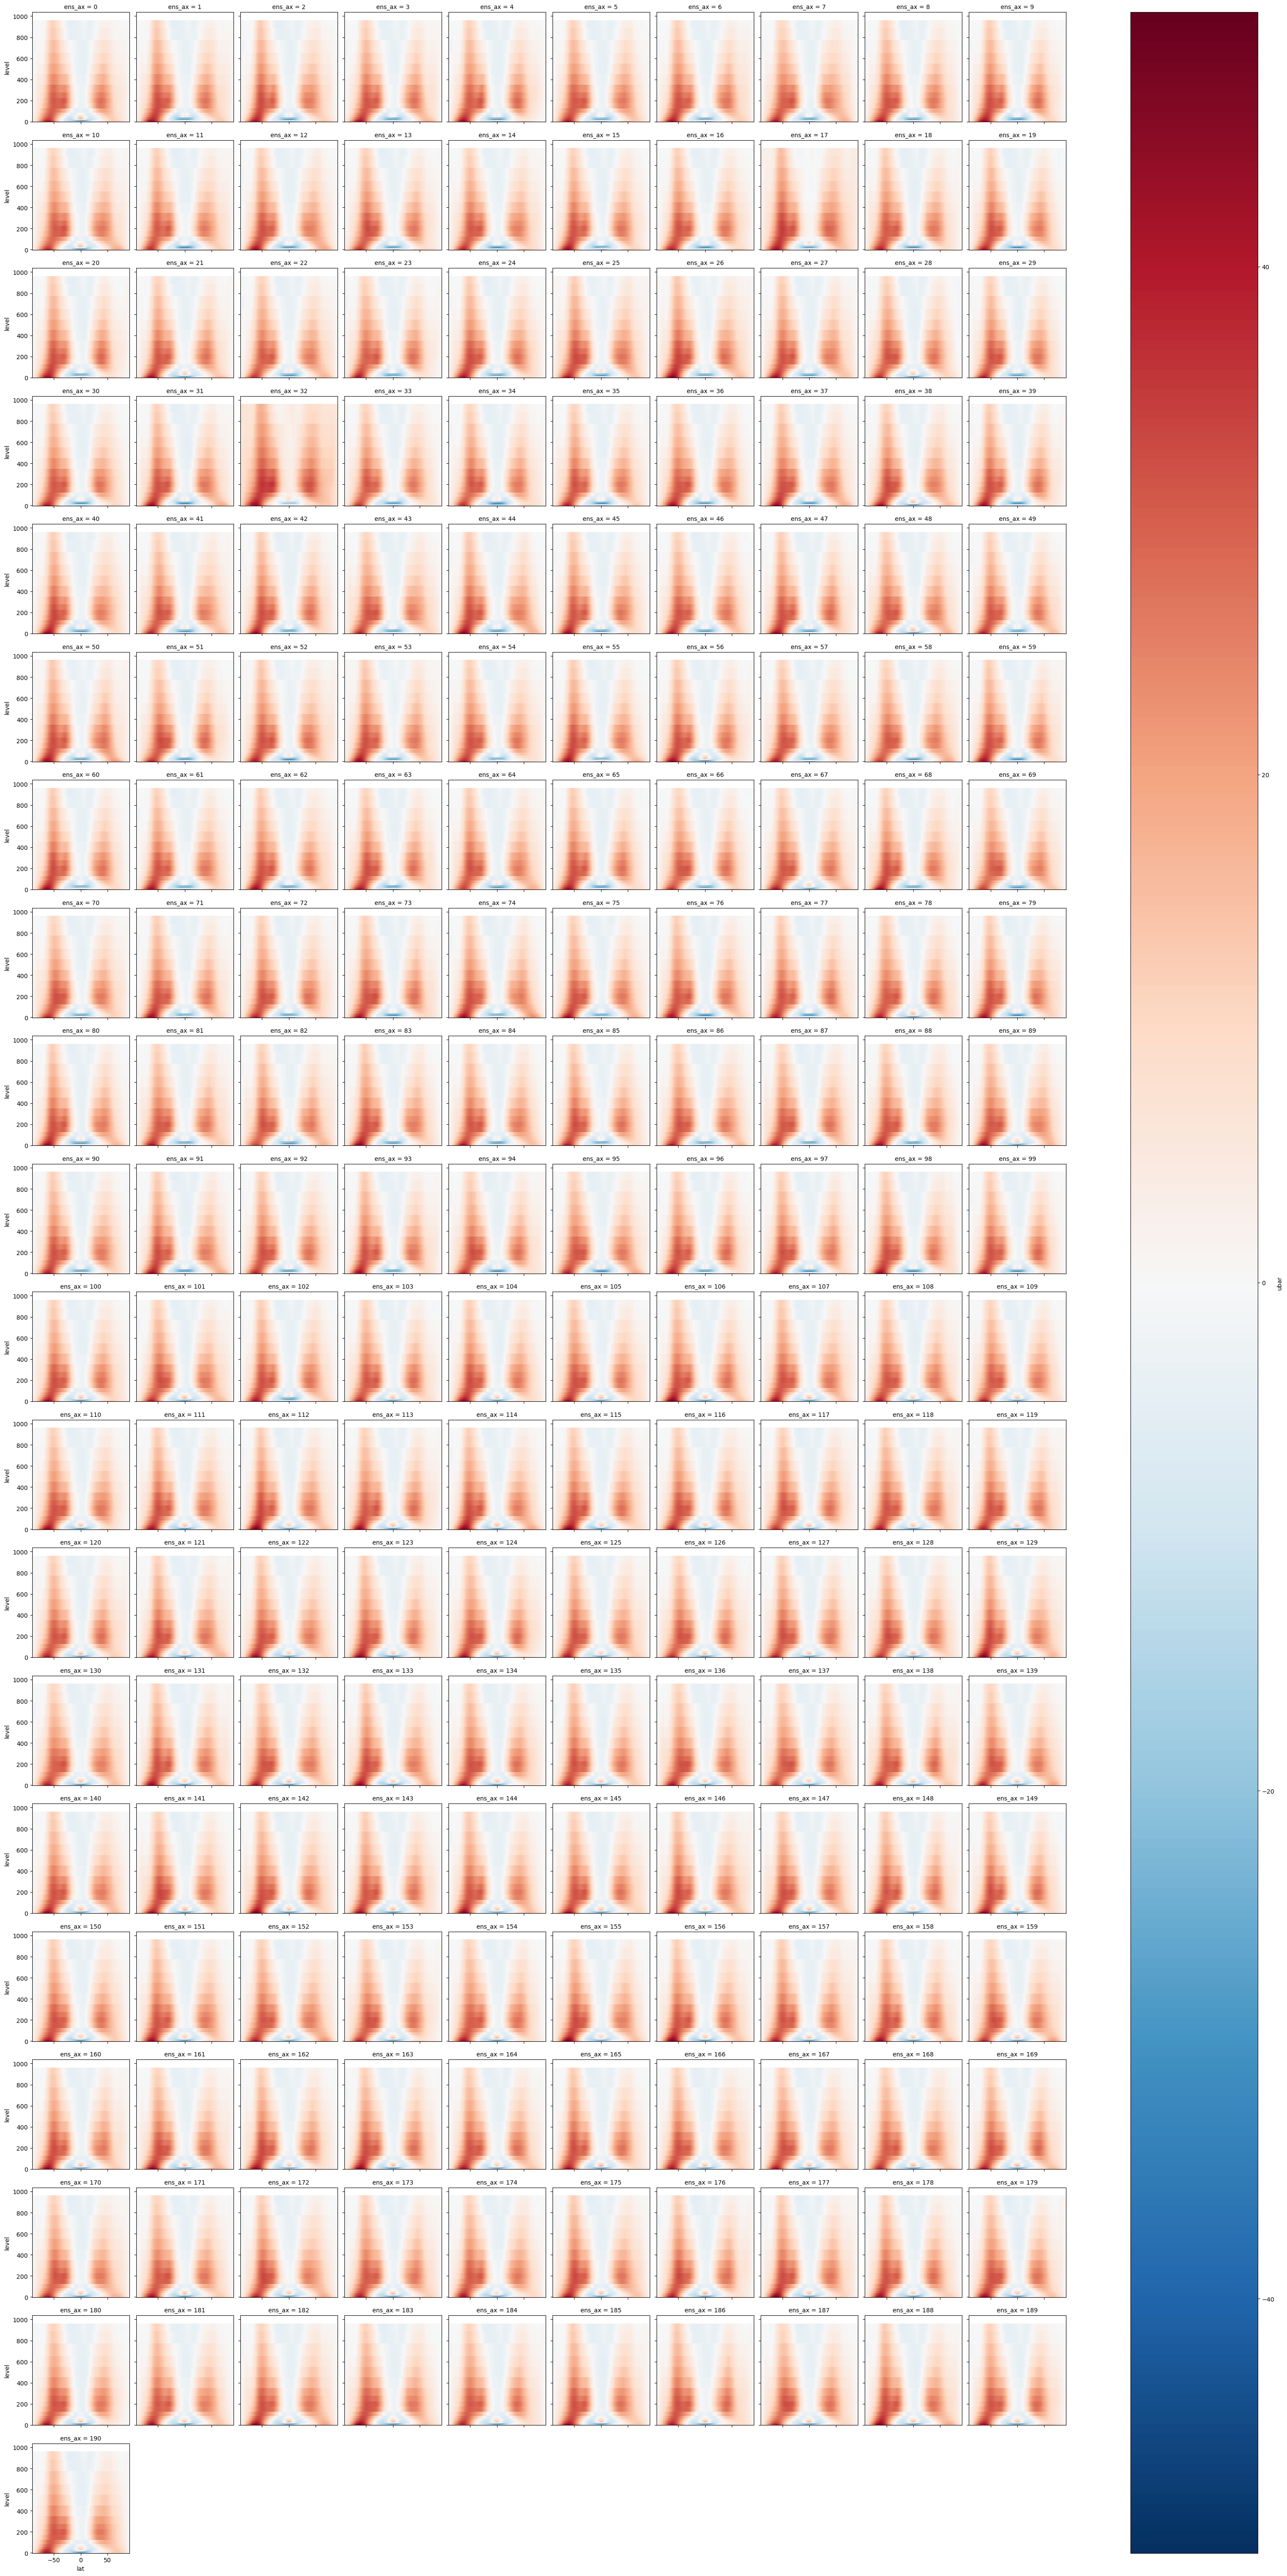

In [18]:
hadll.ubar.mean(dim='time').plot(col='ens_ax', col_wrap=10)

In [8]:
hadll

<xarray.Dataset> Size: 5GB
Dimensions:  (ens_ax: 199, time: 11, level: 19, lat: 145, lon: 192)
Coordinates:
  * lon      (lon) float32 768B 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float32 580B -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * level    (level) float32 76B 1e+03 925.0 850.0 700.0 ... 20.0 10.0 5.0 1.0
  * time     (time) object 88B 2000-06-01 00:00:00 ... 2001-04-01 00:00:00
Dimensions without coordinates: ens_ax
Data variables:
    u        (ens_ax, time, level, lat, lon) float32 5GB dask.array<chunksize=(1, 11, 19, 145, 192), meta=np.ndarray>
    epfy     (ens_ax, time, level, lat) float32 24MB dask.array<chunksize=(1, 11, 19, 145), meta=np.ndarray>
    divFy    (ens_ax, time, level, lat) float32 24MB dask.array<chunksize=(1, 11, 19, 145), meta=np.ndarray>
    ubar     (ens_ax, time, level, lat) float32 24MB dask.array<chunksize=(1, 11, 19, 145), meta=np.ndarray>

### HadGEM3-GC31-MM

- Only has 8 levels?
- no data for divFy....

In [9]:
hadmm = hadmm.sel(time=hadmm.time.dt.month.isin([12,1,2]))
hadmm

<xarray.Dataset> Size: 4GB
Dimensions:  (ens_ax: 300, time: 3, level: 8, lat: 325, lon: 432)
Coordinates:
  * level    (level) float64 64B 1e+03 850.0 700.0 500.0 250.0 100.0 50.0 10.0
  * lat      (lat) float64 3kB -90.0 -89.44 -88.89 -88.33 ... 88.89 89.44 90.0
  * lon      (lon) float64 3kB 0.0 0.8333 1.667 2.5 ... 356.7 357.5 358.3 359.2
  * time     (time) object 24B 2000-12-01 00:00:00 ... 2001-02-01 00:00:00
Dimensions without coordinates: ens_ax
Data variables:
    u        (ens_ax, time, level, lat, lon) float32 4GB dask.array<chunksize=(1, 3, 8, 325, 432), meta=np.ndarray>
    epfy     (ens_ax, time, level, lat) float64 19MB dask.array<chunksize=(1, 3, 8, 325), meta=np.ndarray>
    divFy    (ens_ax, time, level, lat) float64 19MB dask.array<chunksize=(1, 3, 8, 325), meta=np.ndarray>
    ubar     (ens_ax, time, level, lat) float32 9MB dask.array<chunksize=(1, 3, 8, 325), meta=np.ndarray>

In [10]:
# hadmm.ubar.mean(dim='time').plot(col='ens_ax', col_wrap=10)

In [11]:
# hadmm.divFy.mean(dim='time').plot(col='ens_ax', col_wrap=10)

In [12]:
path = '/home/links/ct715/data_storage/PAMIP/processed_monthly/efp_pd_non-regridded'
files = os.listdir(path)
files = [f for f in files if f.endswith('.nc')]
files.sort()
model_list = [os.path.basename(f).split('_')[0] for f in files]

ds_mon = {}
for model in model_list:
    dataset = xr.open_mfdataset(os.path.join(path, f'{model}_*.nc'))
    ds_mon[model] = dataset

In [13]:
ds_mon['HadGEM3-GC31-MM']

<xarray.Dataset> Size: 415MB
Dimensions:  (time: 14, level: 19, lat: 325, ens_ax: 300)
Coordinates:
  * time     (time) object 112B 2000-04-16 00:00:00 ... 2001-05-16 00:00:00
  * level    (level) float64 152B 1e+03 925.0 850.0 700.0 ... 20.0 10.0 5.0 1.0
  * lat      (lat) float64 3kB -90.0 -89.44 -88.89 -88.33 ... 88.89 89.44 90.0
Dimensions without coordinates: ens_ax
Data variables:
    ubar     (ens_ax, time, level, lat) float32 104MB dask.array<chunksize=(300, 14, 19, 325), meta=np.ndarray>
    epfy     (ens_ax, time, level, lat) float32 104MB dask.array<chunksize=(300, 14, 19, 325), meta=np.ndarray>
    divFy    (ens_ax, time, level, lat) float64 207MB dask.array<chunksize=(300, 14, 19, 325), meta=np.ndarray>